In [41]:
#Creators -
#Shreejit Gajanan Deshmukh
#Venkata Sai Advaith Kandiraju
#PRCV Spring 2023' Assignment 5 - Deep learning

In [ ]:
#Summary -
#This program transfers our learned weights of digits recognition with the new inputs i.e. greek letters. 
#The output layer will be changed to 3 since we are only learning first 3 greek letters, and we train our
#network again till we reach a good accuracy.

In [42]:
#Importing libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [43]:
#Defining neural networks parameters
#batch sizes for train and test
batch_size_train = 1
batch_size_test = 1

#Hyperparameters
learning_rate = 0.02
momentum = 0.5
log_interval = 10

#Network parameters for random initialization and using CPU
random_seed = 6
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [44]:
#Building the network with 2 convolution layers and following Relu, pooling and dropout layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [45]:
#Initializing our neural network
trained_NN = Net()

In [46]:
#Loading the saved model
network_state_dict = torch.load('results/model.pth')
trained_NN.load_state_dict(network_state_dict)

<All keys matched successfully>

In [47]:
#Freezes the parameters for the whole network
for param in trained_NN.parameters():
    param.requires_grad = False

In [48]:
#Checking the loaded model and the last layer which needs to be changed
summary(trained_NN)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (260)
├─Conv2d: 1-2                            (5,020)
├─Dropout2d: 1-3                         --
├─Linear: 1-4                            (16,050)
├─Linear: 1-5                            (510)
Total params: 21,840
Trainable params: 0
Non-trainable params: 21,840


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (260)
├─Conv2d: 1-2                            (5,020)
├─Dropout2d: 1-3                         --
├─Linear: 1-4                            (16,050)
├─Linear: 1-5                            (510)
Total params: 21,840
Trainable params: 0
Non-trainable params: 21,840

In [49]:
#Changing the output layer to output only three results
trained_NN.fc2 = nn.Linear(50,3)
for _, param in trained_NN.fc2._parameters.items():
    param.requires_grad = True

#Checking the model after updating the neural network
summary(trained_NN)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (260)
├─Conv2d: 1-2                            (5,020)
├─Dropout2d: 1-3                         --
├─Linear: 1-4                            (16,050)
├─Linear: 1-5                            153
Total params: 21,483
Trainable params: 153
Non-trainable params: 21,330


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (260)
├─Conv2d: 1-2                            (5,020)
├─Dropout2d: 1-3                         --
├─Linear: 1-4                            (16,050)
├─Linear: 1-5                            153
Total params: 21,483
Trainable params: 153
Non-trainable params: 21,330

In [50]:
#Initializing the optimizer
trained_optimizer = optim.SGD(trained_NN.parameters(), lr=learning_rate,
                      momentum=momentum)

In [51]:
# greek data set transform
class GreekTransform:
    def __init__(self):
        pass

    def __call__(self, x):
        x = torchvision.transforms.functional.rgb_to_grayscale( x )
        x = torchvision.transforms.functional.affine( x, 0, (0,0), 36/128, 0 )
        x = torchvision.transforms.functional.center_crop( x, (28, 28) )
        return torchvision.transforms.functional.invert( x )

In [52]:
# DataLoader for the Greek data set
training_set_path = "D:/OpenCV/Project5_Deep_learning/greek_train"
greek_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder( training_set_path,
                                      transform = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),
                                                                                   GreekTransform(),
                                                                                   torchvision.transforms.Normalize(
                                                                                       (0.1307,), (0.3081,) ) ] ) ),
    batch_size = 1,
    shuffle = True )

#for testing using the same data since we need 100% accuracy on train
greek_test = greek_train

In [53]:
#Initializing trackers for later analysis of our training
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(greek_train.dataset) for i in range(n_epochs + 1)]

In [54]:
#This function for each epoch performs forward feed and then calculates loss. Then the loss is back propagated to optimize
#the weights of the network. We are printing values for batches for better tracking the progress of our network.
def train(epoch):
    trained_NN.train()
    for batch_idx, (data, target) in enumerate(greek_train):
        #Setting the gradient to zero
        trained_optimizer.zero_grad()
        
        output = trained_NN(data)
        
        loss = F.nll_loss(output, target)
        
        loss.backward()
        
        trained_optimizer.step()
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, (batch_idx + 1) * len(data), len(greek_train.dataset),
            100. * (batch_idx + 1) / len(greek_train), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx) + ((epoch-1)*len(greek_train.dataset)))

In [55]:
#This function performs testing on the test set. It just compares our prediction for the hand drawn digit to the ground 
#truth, then it returns the correct prediction accuracy for the test set.
def test():
    trained_NN.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in greek_test:
            output = trained_NN(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        
        test_loss /= len(greek_test.dataset)
        
        test_losses.append(test_loss)
        
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(greek_test.dataset),
            100. * correct / len(greek_test.dataset)))
        
        if correct / len(greek_test.dataset) == 1:
            stop = 1

In [56]:
#Stop variable which stops training when accuracy is 100%
stop = 0

#Performing the train-test cycles for our predefined number of epochs.
#We perform test once before training to see the random matching of our prediction v/s ground truth for test set.
for i in range(12):
    test_counter.append(i*len(greek_train.dataset))
    train(i + 1)
    test()
    if stop == 1:
        break

C:\Users\shree\AppData\Local\Temp\ipykernel_18908\3091214926.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1/27 (4%)]	Loss: 1.084618
Train Epoch: 1 [2/27 (7%)]	Loss: 1.216013
Train Epoch: 1 [3/27 (11%)]	Loss: 0.957168
Train Epoch: 1 [4/27 (15%)]	Loss: 0.876135
Train Epoch: 1 [5/27 (19%)]	Loss: 1.689580
Train Epoch: 1 [6/27 (22%)]	Loss: 0.716800
Train Epoch: 1 [7/27 (26%)]	Loss: 1.593224
Train Epoch: 1 [8/27 (30%)]	Loss: 1.056084
Train Epoch: 1 [9/27 (33%)]	Loss: 1.155882
Train Epoch: 1 [10/27 (37%)]	Loss: 1.180787
Train Epoch: 1 [11/27 (41%)]	Loss: 0.650603
Train Epoch: 1 [12/27 (44%)]	Loss: 0.921617
Train Epoch: 1 [13/27 (48%)]	Loss: 0.676056
Train Epoch: 1 [14/27 (52%)]	Loss: 1.332573
Train Epoch: 1 [15/27 (56%)]	Loss: 1.019382
Train Epoch: 1 [16/27 (59%)]	Loss: 1.685479
Train Epoch: 1 [17/27 (63%)]	Loss: 2.133908
Train Epoch: 1 [18/27 (67%)]	Loss: 1.047575
Train Epoch: 1 [19/27 (70%)]	Loss: 0.680882
Train Epoch: 1 [20/27 (74%)]	Loss: 1.243344
Train Epoch: 1 [21/27 (78%)]	Loss: 0.368759
Train Epoch: 1 [22/27 (81%)]	Loss: 0.089691
Train Epoch: 1 [23/27 (85%)]	Loss: 0.845165

Train Epoch: 7 [21/27 (78%)]	Loss: 0.252107
Train Epoch: 7 [22/27 (81%)]	Loss: 0.567243
Train Epoch: 7 [23/27 (85%)]	Loss: 0.045074
Train Epoch: 7 [24/27 (89%)]	Loss: 0.096225
Train Epoch: 7 [25/27 (93%)]	Loss: 0.585394
Train Epoch: 7 [26/27 (96%)]	Loss: 0.140890
Train Epoch: 7 [27/27 (100%)]	Loss: 0.338508

Test set: Avg. loss: 0.2516, Accuracy: 26/27 (96%)

Train Epoch: 8 [1/27 (4%)]	Loss: 0.017422
Train Epoch: 8 [2/27 (7%)]	Loss: 0.101166
Train Epoch: 8 [3/27 (11%)]	Loss: 0.059905
Train Epoch: 8 [4/27 (15%)]	Loss: 0.823900
Train Epoch: 8 [5/27 (19%)]	Loss: 0.840107
Train Epoch: 8 [6/27 (22%)]	Loss: 0.425176
Train Epoch: 8 [7/27 (26%)]	Loss: 0.005111
Train Epoch: 8 [8/27 (30%)]	Loss: 0.668197
Train Epoch: 8 [9/27 (33%)]	Loss: 0.093187
Train Epoch: 8 [10/27 (37%)]	Loss: 0.304850
Train Epoch: 8 [11/27 (41%)]	Loss: 0.345467
Train Epoch: 8 [12/27 (44%)]	Loss: 0.187652
Train Epoch: 8 [13/27 (48%)]	Loss: 0.425915
Train Epoch: 8 [14/27 (52%)]	Loss: 1.193302
Train Epoch: 8 [15/27 (56%)]	Loss

Text(0, 0.5, 'negative log likelihood loss')

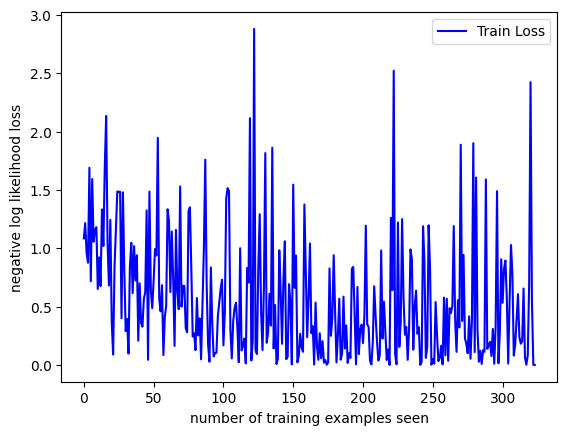

In [58]:
#Plotting the progress of our network. Log values of train loss in blue.
fig = plt.figure()
plt.plot(train_counter, train_losses, color = 'blue')
# plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [59]:
# Loading the hand drawn greek letters using DataLoader
testing_set_path = "D:/OpenCV/Project5_Deep_learning/greek_test"
greek_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder( testing_set_path,
                                      transform = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),
                                                                                   GreekTransform(),
                                                                                   torchvision.transforms.Normalize(
                                                                                       (0.1307,), (0.3081,) ) ] ) ),
    batch_size = 1,
    shuffle = True )


In [60]:
#Finding accuracy of our trained model on the hand drawn greek letters
test()


Test set: Avg. loss: 0.8956, Accuracy: 12/15 (80%)



C:\Users\shree\AppData\Local\Temp\ipykernel_18908\3091214926.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
